In [4]:
import numpy as np
import matplotlib.pyplot as plt
from da.l63 import gen_l63, max_lyapunov_exponent_l63
from da.scheme import rk4
from da.loss import loss_rms
from da.visualize import plot_loss
from da.etkf import ETKF

In [16]:
# params
s = 10
b = 8/3
r = 28

# dt: 時間刻み
Dt = 0.05

lorenz = gen_l63(s, r, b)
# モデルの遷移関数(非線形)
# 0.01ずつ時間発展させる
# dtは同化step
def M(x, dt):
    for i in range(int(dt/0.01)):
        x = rk4(lorenz, 0, x, 0.01)
    return x

# 単位行列
I = np.eye(3)

# 観測
H = I
# H = np.eye(1,3)
# H = np.eye(2,3)

# モデル誤差共分散, 最初は完全モデルを仮定
Q = np.zeros((3, 3))

# 観測誤差共分散, 後で定数倍の変化をさせる.
r0 = 1
R = r0*I

# 観測値と真値
end_step = -1 # 開発用
x_true = np.load('x_true_l63.npy')[:end_step]
y = np.load('x_obs_l63.npy')[:end_step]
if not np.isclose(r0, 1.0):
    y = x_true + np.random.normal(loc=0, scale=r0, size=x_true.shape) # R = r0*I

y = y@H.T
R = H@R@H.T

# KFの初期値
seed = 1
np.random.seed(seed)
x_0 = x_true[np.random.randint(len(x_true)-1)]

P_0 = 64*I

# inflation
alpha = 1.0
m = 15

In [17]:
# RUN DA
etkf = ETKF(M, H, R, x_0, P_0, m=m, alpha=alpha, seed=seed, store_ensemble=True)
for y_obs in y:
    etkf.forecast(Dt)
    etkf.update(y_obs)

x_assim = etkf.x

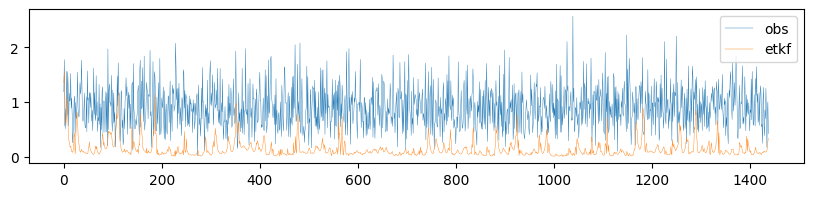

In [18]:
# Plot
fig, ax = plt.subplots(figsize=(10, 2))
plot_loss(x_true@H.T, y, loss_rms, ax=ax, label='obs', lw=0.3)
plot_loss(x_true, x_assim, loss_rms, ax=ax, label='etkf', lw=0.3)
ax.legend()
# ax.set_ylim([0, 2])
plt.show()

## Covariance

In [19]:
from da.stats import cov
# forecast ensemble covariance
X_f = np.array(etkf.X_f)
print(X_f.shape)
P_f = [cov(X) for X in X_f]

# analysis ensemble covariance
X_a = np.array(etkf.X_a)
print(X_a.shape)
P_a = [cov(X) for X in X_a]

# forecast - true
E_f = X_f.mean(axis=1) - x_true
print(E_f.shape)
e_f = np.linalg.norm(E_f, axis=1)/(3-1)

# analysis - true
E_a = X_a.mean(axis=1) - x_true
print(E_a.shape)
e_a = np.linalg.norm(E_a, axis=1)/(3-1)

(1439, 15, 3)
(1439, 15, 3)
(1439, 3)
(1439, 3)


In [20]:
import scipy.linalg as spl

# 以下が成り立って欲しいが固有値分解の自由度のせいで固有ベクトルが一致しない．
# for i in range(len(P_f)):
#     assert np.allclose(spl.eig(P_f[i])[1], spl.eig(P_a[i])[1]), (spl.eig(P_f[i])[1], spl.eig(P_a[i])[1])

# lambda_f -> lambda_a: ETKF updateによる固有値の変化の確認
for i in range(len(P_f)):
    lam_f = spl.eig(P_f[i])[0]
    lam_a = spl.eig(P_a[i])[0]
    lam_a_theory = alpha**2*lam_f/(1+alpha**2*lam_f)
    lam_a_theory.sort()
    lam_a.sort()
    assert np.allclose(lam_a, lam_a_theory), (lam_a, lam_a_theory)

## trace(P) vs. RMSE

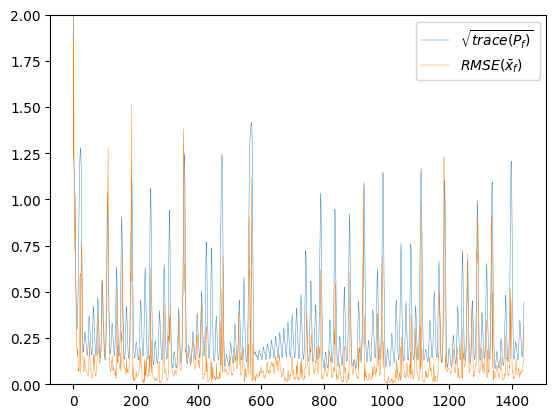

In [23]:
trP_f = [np.sqrt(np.trace(P)) for P in P_f]
plt.plot(trP_f, lw=0.3, label="$ \\sqrt{trace(P_f)} $")
plt.plot(e_f, lw=0.3, label="$ RMSE(\\bar{x}_f)$")
plt.ylim(0, 2)
plt.legend()

In [24]:
# import scipy.linalg as spl

# imax = 100 # len(P_f)
# for i in range(imax):
#     lam_f = spl.eig(P_f[i])[0]
    
#     trP = np.sqrt(np.trace(P_f[i]))
#     if (trP < e_f[i]):
#         color = "\x1b[31m"  # red color
#     else:
#         color = "\x1b[0m"  # No color
#     print(f"{color}{lam_f}{color}")
#     print(f"{color}{trP}, {e_f[i]}{color}")
#     print("\x1b[0m----\x1b[0m")

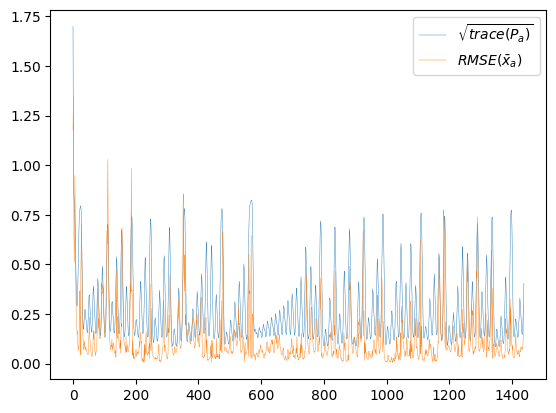

In [25]:
trP_a = [np.sqrt(np.trace(P)) for P in P_a]
plt.plot(trP_a, lw=0.3, label="$ \\sqrt{trace(P_a)} $")
plt.plot(e_a, lw=0.3, label="$ RMSE(\\bar{x}_a)$")
plt.legend()

In [26]:
# import scipy.linalg as spl

# imax = 50 # len(P_a)
# for i in range(imax):
#     lam_a = spl.eig(P_a[i])[0]
#     trP = np.sqrt(np.trace(P_a[i]))
#     if (trP < e_a[i]):
#         color = "\x1b[31m"  # red color
#     else:
#         color = "\x1b[0m"  # No color
#     print(f"{color}{lam_a}{color}")
#     print(f"{color}{trP}, {e_a[i]}{color}")
#     print("\x1b[0m----\x1b[0m")
